<a href="https://colab.research.google.com/github/RAGISHIVANAND/DEEP_LEARNING/blob/main/Copy_of_HEART_RATE_TENSOR_FLOW_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import pandas as pd

file_path = '/content/drive/MyDrive/Colab Notebooks/heart.csv'

heart_df = pd.read_csv(file_path)           

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
heart_df.head()

,age,sex,chest_pain,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_ecg_results,max_heart_rate_achieved,exercise_induced_angina,oldpeak,slope of the peak,num_of_major_vessels,thal,heart_disease
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
heart_df.shape

(269, 14)

In [ ]:
import numpy as np
import warnings
warnings.filterwarnings("ignore") #suppresswarnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#convert imput to numpy arrays
x = heart_df.drop(columns=['heart_disease'])

#replace target class with 0 and 1
#1 means "have heart disease " and 0 means "do not have heart disease"
heart_df['heart_disease']=heart_df['heart_disease'].replace(1,0)
heart_df['heart_disease']=heart_df['heart_disease'].replace(1,0)

y_label=heart_df['heart_disease'].values.reshape(x.shape[0],1)


#split data into train and test set
xtrain,xtest,ytrain,ytest=train_test_split(x,y_label,test_size=0.2,random_state=2)

#standardize the dataset
sc=StandardScaler()
sc.fit(xtrain)
xtrain=sc.transform(xtrain)
xtest=sc.transform(xtest)

print(f"shape of train set is {xtrain.shape}")
print(f"shape of test set is {xtest.shape}")
print(f"shape of train label is {ytrain.shape}")
print(f"shape of test label is {ytest.shape}")

shape of train set is (215, 13)
shape of test set is (54, 13)
shape of train label is (215, 1)
shape of test label is (54, 1)


In [ ]:
class NeuralNet():
    '''
    A two layer neural network
    '''
    def __init__(self,layers=[13,8,1],learning_rate=0.001,iterations=100):
        self.params={}
        self.learning_rate = learning_rate
        self.iterations=iterations
        self.loss=[]
        self.sample_size=None
        self.layers=layers
        self.x=None
        self.y=None


    def init_weights(self):
        '''
        Initialize the weights from a random normal distribution

        '''
        np.random.seed(1)#seed the random number generator

        self.params["w1"]=np.random.randn(self.layers[0],self.layers[1])
        self.params['b1']=np.random.randn(self.layers[1],)
        self.params['w2']=np.random.randn(self.layers[1],self.layers[2])
        self.params['b2']=np.random.randn(self.layers[2],)

    def relu(self,Z):
        '''
        The Relu activation function is to performs
        a threshold operation to each input element
        where values less than zero are set to zero.
        '''
        return np.maximum(0,Z)

    def dRelu(self,x):
        x[x<=0]=0
        x[x>0]=1
        return x
    def eta(self,x):
      ETA =0.0000000001                  
      return np.maximum(x,ETA)


    def sigmoid(self,z):
        '''
        The sigmoid function takes in real numbers in any range and
        squashes it to a real_valued output between 0 and 1.
        '''
        return 1/(1+np.exp(-z))


    def entropy_loss(self,y,yhat):
        nsample = len(y)
        yhat_inv = 1.0-yhat
        y_inv = 1.0-y
        yhat=self.eta(yhat)##clips value to avoid NaNs in log
        yhat_inv=self.eta(yhat_inv)
        loss=-1/nsample*(np.sum(np.multiply(np.log(yhat),y)+np.multiply((y_inv),np.log(yhat_inv))))
        return loss


    def forward_propagation(self):
        '''
        performs the forward propagation
        '''
        Z1 = self.x.dot(self.params['w1'])+self.params['b1'] 
        A1=self.relu(Z1)
        Z2 = A1.dot(self.params['w2'])+self.params['b2']
        yhat = self.sigmoid(Z2) 
        loss = self.entropy_loss(self.y,yhat)

        #save calculated parameters
        self.params['Z1']=Z1
        self.params['Z2']=Z2
        self.params['A1']=A1

        return yhat,loss

    def back_propagation(self,yhat):
        '''
        computes the derivatives and update weights and bias according
        '''
        y_inv = 1-self.y
        yhat_inv=1-yhat
        d1_wrt_yhat=np.divide(y_inv,self.eta(yhat_inv))-np.divide(self.y,self.eta(yhat))
        d1_wrt_sig=yhat*(yhat_inv)
        d1_wrt_Z2=d1_wrt_yhat*d1_wrt_sig

        d1_wrt_A1 = d1_wrt_Z2.dot(self.params['w2'].T)
        d1_wrt_W2 =self.params['A1'].T.dot(d1_wrt_Z2)
        d1_wrt_b2 = np.sum(d1_wrt_Z2,axis=0,keepdims=True)

        d1_wrtr_Z1=d1_wrt_A1*self.dRelu(self.params['Z1'])
        d1_wrt_W1=self.x.T.dot(d1_wrtr_Z1)
        d1_wrt_b1=np.sum(d1_wrtr_Z1,axis=0,keepdims=True)

        #update the weights and bias 
        self.params['w1']=self.params['w1']-self.learning_rate*d1_wrt_W1
        self.params['w2']=self.params['w2']-self.learning_rate*d1_wrt_W2
        self.params['b1']=self.params['b1']-self.learning_rate*d1_wrt_b1
        self.params['b2']=self.params['b2']-self.learning_rate*d1_wrt_b2

    def fit(self,x,y):
        '''
        Trains the neural network using the specified data and labels
        '''

        self.x = x
        self.y = y
        self.init_weights()#initialize weights and bias

        for i in range(self.iterations):
            yhat,loss = self.forward_propagation()
            self.back_propagation(yhat)
            self.loss.append(loss)
    def predict(self,x):
        '''
        predicts on a test data
        '''
        Z1 = x.dot(self.params['w1'])+self.params['b1']
        A1= self.relu(Z1)
        Z2=A1.dot(self.params['w2'])+self.params['b2']
        pred = self.sigmoid(Z2)
        return np.round(pred)



    def acc(self,y,yhat):
        '''
        calculates the accutacy between the predicted valuea and the truth labels
        '''
        acc = int(sum(y == yhat)/len(y)*100)
        return acc

    def plot_loss(self):
        '''
        plots the loss curve
        '''
        plt.plot(self.loss)
        plt.xlabel("Iteration")
        plt.ylabel("logloss")
        plt.title("Loss curve for training")
        plt.show()                      

In [ ]:
nn= NeuralNet() #create the NNmodel
nn.fit(xtrain,ytrain) #train the model

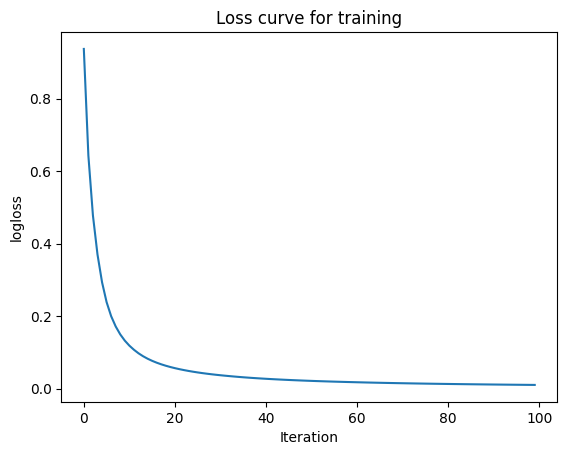

In [ ]:
nn.plot_loss()

In [ ]:
nn.predict(xtest)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])